In [1]:
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import gc
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

# 그래프 한글 깨짐 방지
if platform.system() == 'Darwin':
    # 맥일때
    plt.rcParams["font.family"] = 'AppleGothic'
elif platform.system() == 'Windows':
    # 윈도우일때
    plt.rcParams["font.family"] = 'Malgun Gothic'

# 마이너스기호(-) 폰트 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 디렉토리 파일 확인
import os
print(os.listdir("./input_2019-2nd-ml-month-with-kakr/"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [4]:
# train, test 데이터 read(dataframe)
train = pd.read_csv("./input_2019-2nd-ml-month-with-kakr/train.csv")
test = pd.read_csv("./input_2019-2nd-ml-month-with-kakr/test.csv")

In [5]:
train.shape

(15035, 21)

In [6]:
test.shape

(6468, 20)

In [7]:
# train 데이터셋을 학습에 사용할 train feature 데이터프레임에 추가(price 칼럼 제외)
X_train = train.drop("price", axis=1)

In [8]:
# 트레인 데이터 date( ID 칼럼 삭제
del X_train["id"]
del X_train["date"]

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 18 columns):
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null int64
sqft_lot         15035 non-null int64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null int64
sqft_basement    15035 non-null int64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
dtypes: float64(4), int64(14)
memory usage: 2.1 MB


In [14]:
# 학습 결과 확인용 lable만으로 데이터 프레임 제작
# log scale 로 변환
Y_train = np.log(train["price"])

C:\Users\Cho Min\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



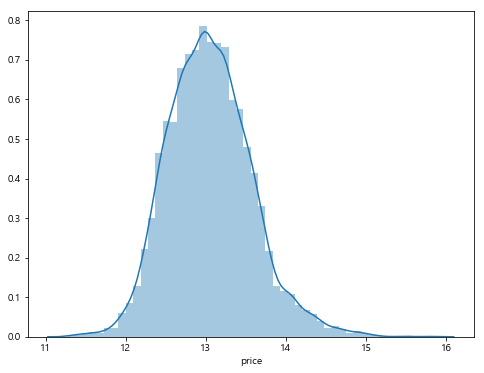

In [16]:
#price 가격에 대한 분포도 변화 확인)
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(Y_train)

In [13]:
# 위와 같은 방법으로 결과 테스트(예측)를 위한 데이터 프레임 카피
X_test = test.copy()
del X_test["id"]
del X_test["date"]

In [14]:
# Decision Tree Regressor를 이용한 훈련
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

decition_tree_regressor = DecisionTreeRegressor()
decition_tree_regressor.fit(X_train, Y_train)
Y_pred = decition_tree_regressor.predict(X_train)
decition_tree_regressor_mse = mean_squared_error(Y_pred, Y_train)
decition_tree_regressor_rmse = np.sqrt(decition_tree_regressor_mse)
decition_tree_regressor_rmse

1.8396538650100402e-05

In [15]:
# 데이터셋 분할하여 확인
from sklearn.model_selection import cross_val_score

scores = cross_val_score(decition_tree_regressor, X_train, Y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [17]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [0.25317102 0.25546988 0.26020029 0.25639912 0.25301095 0.26357338
 0.263732   0.24305136 0.25783184 0.22843489]
Mean: 0.25348747208877853
Standard deviation: 0.010098962923961126


In [18]:
# Random Forest Regressor를 이용한 훈련
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, Y_train)
Y_pred = forest_reg.predict(X_train)
forest_mse = mean_squared_error(Y_pred, Y_train)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.07823276523328077

In [19]:
# 나무 100개로 훈련
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(X_train, Y_train)
Y_pred = forest_reg.predict(X_train)
forest_mse = mean_squared_error(Y_pred, Y_train)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.06559714270403116

In [20]:
scores = cross_val_score(forest_reg, X_train, Y_train,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(forest_rmse_scores)

Scores: [0.17672344 0.17960037 0.1852072  0.18000176 0.18149979 0.18564346
 0.17477093 0.18023872 0.18153875 0.15538771]
Mean: 0.17806121199286504
Standard deviation: 0.008185672659859894


In [21]:
# Random Forest로 정답제출용 submission 데이터프레임 작성

forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(X_train, Y_train)
Y_pred = forest_reg.predict(X_test)

submission = pd.DataFrame({
        "id": test["id"],
        "price": np.exp(Y_pred)
    })
submission.shape

(6468, 2)

In [23]:
submission.head(10)

,id,price
0,15035,4.894988e+05
1,15036,5.111506e+05
2,15037,1.357496e+06
3,15038,3.007536e+05
4,15039,3.214139e+05
5,15040,3.232557e+05
6,15041,4.549915e+05
7,15042,7.092519e+05
8,15043,3.056795e+05
9,15044,5.167608e+05


In [24]:
# 정답제출용 데이터 프레임으로 정답제출 파일 작성
submission.to_csv('submission_HPP_rf1.csv', index=False)